In [1]:
%reload_ext autoreload
%load_ext autoreload
%autoreload 2
import sys; 
CPBdir = "../.."
sys.path.append(CPBdir+"/src");
sys.path.append(CPBdir);
sys.path.append("../../..");sys.path.append(".."); 
sys.path.append(CPBdir+"/src/python_modules");
sys.path.append("../build-cmake/cpp/python_binding/") # dumux python binding
sys.path.append("../../build-cmake/cpp/python_binding/")
sys.path.append("../modules/") # python wrappers 
#import reload
%reload_ext autoreload
import helpuqrMasterCopy1
import importlib
importlib.reload(helpuqrMasterCopy1)
from helpuqrMasterCopy1 import *
from helpuqrMasterCopy1 import setKrKx_xylem
#reload(helpuqrMasterCopy1)
import numpy as np


def weather(simDuration, hp,condition):
    vgSoil = [0.059, 0.45, 0.00644, 1.503, 1]
    loam = [0.08, 0.43, 0.04, 1.6, 50]
    Qnigh = 0; Qday = 960e-6 #458*2.1
    if (condition == "wet"):
        Tnigh = 15.8; Tday = 22
        #Tnigh = 13; Tday = 20.7
        #specificHumidity = 0.0097
        RHday = 0.60; RHnigh = 0.88
        Pair = 1010.00 #hPa
        thetaInit = 40/100#15.59/100#
        cs = 350e-6
    elif condition == "dry":
        Tnigh = 20.7; Tday = 30.27
        #Tnigh = 15.34; Tday = 23.31
        #specificHumidity = 0.0097# 0.0111
        RHday = 0.3; RHnigh = 0.78
        Pair = 1070.00 #hPa
        thetaInit = 28/100#10.47/100#   
        cs = 350e-6
    else:
        print("condition",condition)
        raise Exception("condition not recognised")
    coefhours = sinusoidal(simDuration)
    RH_ = RHnigh + (RHday - RHnigh) * coefhours
    TairC_ = Tnigh + (Tday - Tnigh) * coefhours
    Q_ = Qnigh + (Qday - Qnigh) * coefhours
     #co2 paartial pressure at leaf surface (mol mol-1)
    #390, 1231
    #RH = 0.5 # relative humidity
    es =  6.112 * np.exp((17.67 * TairC_)/(TairC_ + 243.5))
    ea = es*RH_#qair2ea(specificHumidity,  Pair)
    assert ea < es
    #RH = ea/es
    assert ((RH_ > 0) and(RH_ < 1))
    bl_thickness = 1/1000 #m
    diffusivity= 2.5e-5#m2/sfor 25°C
    rbl =bl_thickness/diffusivity #s/m 13
    #cs = 350e-6
    Kcanopymean = 1e-1 # m2/s
    meanCanopyL = (2/3) * hp /2
    rcanopy = meanCanopyL/Kcanopymean
    windSpeed = 2 #m/s
    zmzh = 2 #m
    karman = 0.41 #[-]

    rair = 1
    if hp > 0:
        rair = np.log((zmzh - (2/3)*hp)/(0.123*hp)) * np.log((zmzh - (2/3)*hp)/(0.1*hp)) / (karman*karman*windSpeed)
        #print()
        #raise Exception


    pmean = theta2H(vgSoil, thetaInit)

    weatherVar = {'TairC' : TairC_,'TairK' : TairC_ + 273.15,'Pair':Pair,"es":es,
                    'Qlight': Q_,'rbl':rbl,'rcanopy':rcanopy,'rair':rair,"ea":ea,
                    'cs':cs, 'RH':RH_, 'p_mean':pmean, 'vg':loam}
    #print("Env variables at", round(simDuration//1),"d",round((simDuration%1)*24),"hrs :\n", weatherVar)
    return weatherVar
def resistance2conductance(resistance,r,weatherX):
    resistance = resistance* (1/100) #[s/m] * [m/cm] = [s/cm]
    resistance = resistance * r.R_ph * weatherX["TairK"] / r.Patm # [s/cm] * [K] * [hPa cm3 K−1 mmol−1] * [hPa] = [s] * [cm2 mmol−1]
    resistance = resistance * (1000) * (1/10000)# [s cm2 mmol−1] * [mmol/mol] * [m2/cm2] = [s m2 mol−1]
    return 1/resistance

def initPlant(simDuration, condition):
    weatherInit = weather(0,0, condition)
    #simDuration = 25 # [day] init simtime
    #spellDuration = 5
    simMax = 26#simStartSim+ spellDuration
    depth = 40
    dt = 1/24 #10min
    verbose = True

    # plant system 
    pl = pb.MappedPlant(seednum = 2) #pb.MappedRootSystem() #pb.MappedPlant()
    #pl2 = pb.MappedPlant(seednum = 2) #pb.MappedRootSystem() #pb.MappedPlant()
    path = CPBdir+"/modelparameter/structural/plant/"
    name = "Triticum_aestivum_adapted_2023"#"Triticum_aestivum_adapted_2021"#

    pl.readParameters(path + name + ".xml")
    #pl2.readParameters(path + name + ".xml")



    #raise Exception
    sdf = pb.SDF_PlantBox(np.Inf, np.Inf, depth )

    pl.setGeometry(sdf) # creates soil space to stop roots from growing out of the soil
    #pl2.setGeometry(sdf) # creates soil space to stop roots from growing out of the soil


    pl.initialize(verbose = True)#, stochastic = False)
    pl.simulate(simDuration, False)#, "outputpm15.txt")

    #raise Exception
    """ Coupling to soil """



    min_b = [-3./2, -12./2, -41.]#distance between wheat plants
    max_b = [3./2, 12./2, 0.]
    rez = 0.5
    cell_number = [int(6*rez), int(24*rez), int(40*rez)]#1cm3? 
    layers = depth; soilvolume = (depth / layers) * 3 * 12
    k_soil = []
    initial = weatherInit["p_mean"]#mean matric potential [cm] pressure head

    p_mean = initial
    p_bot = p_mean + depth/2
    p_top = initial - depth/2
    sx = np.linspace(p_top, p_bot, depth)
    picker = lambda x,y,z : max(int(np.floor(-z)),-1) 
    sx_static_bu = sx    
    pl.setSoilGrid(picker)  # maps segment



    """ Parameters phloem and photosynthesis """
    r = PhloemFluxPython(pl,psiXylInit = min(sx),ciInit = weatherInit["cs"]*0.5) #XylemFluxPython(pl)#
    #r2 = PhloemFluxPython(#pl2,psiXylInit = min(sx),ciInit = weatherInit["cs"]*0.5) #XylemFluxPython(pl)#
    

    r = setKrKx_phloem(r)

    r.oldciEq = True

    r.Rd_ref = 0 #to avoid error (C < 0 in meso, mention this in paper)
    r.g0 = 8e-3
    r.VcmaxrefChl1 =1.28
    r.VcmaxrefChl2 = 8.33
    r.a1 = 0.6/0.4#0.7/0.3#0.6/0.4 #ci/(cs - ci) for ci = 0.6*cs
    r.a3 = 1.5
    r.alpha = 0.4#0.2#/2
    r.theta = 0.6#0.9#/2
    r.k_meso = 1e-3#1e-4
    r.setKrm2([[2e-5]])
    r.setKrm1([[10e-2]])#([[2.5e-2]])
    r.setRhoSucrose([[0.51],[0.65],[0.56]])#0.51
    #([[14.4,9.0,0,14.4],[5.,5.],[15.]])
    rootFact = 2
    r.setRmax_st([[2.4*rootFact,1.5*rootFact,0.6*rootFact,2.4*rootFact],[2.,2.],[8.]])#6.0#*6 for roots, *1 for stem, *24/14*1.5 for leaves
    #r.setRmax_st([[12,9.0,6.0,12],[5.,5.],[15.]])
    r.KMrm = 0.1#VERY IMPORTANT TO KEEP IT HIGH
    #r.exud_k = np.array([2.4e-4])#*10#*(1e-1)
    #r.k_gr = 1#0
    r.sameVolume_meso_st = False
    r.sameVolume_meso_seg = True
    r.withInitVal =True
    r.initValST = 0.#0.6#0.0
    r.initValMeso = 0.#0.9#0.0
    r.beta_loading = 0.6
    r.Vmaxloading = 0.05 #mmol/d, needed mean loading rate:  0.3788921068507634
    r.Mloading = 0.2
    r.Gr_Y = 0.8
    r.CSTimin = 0.4
    r.surfMeso=0.0025
    r.leafGrowthZone = 2 # cm
    r.StemGrowthPerPhytomer = True # 
    r.psi_osmo_proto = -10000*1.0197 #schopfer2006
    r.fwr = 0

    r.cs = weatherInit["cs"]

    #r.r_forPhloem(24/14*1.5, 4)
    #r.r_forPhloem(24/14, 3)
    #r.r_forPhloem(6, 2) #because roots will have high C_ST less often
    r.expression = 6
    r.update_viscosity = True
    r.solver = 1
    r.atol = 1e-10
    r.rtol = 1e-6
    #r.doNewtonRaphson = False;r.doOldEq = False
    SPAD= 41.0
    chl_ = (0.114 *(SPAD**2)+ 7.39 *SPAD+ 10.6)/10
    r.Chl = np.array( [chl_]) 
    r.Csoil = 1e-4
    
    hp = max([tempnode[2] for tempnode in r.get_nodes()]) /100 

    weatherX = weather(simDuration, hp,condition)
    r.Patm = weatherX["Pair"]
    ##resistances
    r.g_bl = resistance2conductance(weatherX["rbl"],r,weatherX) / r.a2_bl
    r.g_canopy = resistance2conductance(weatherX["rcanopy"],r,weatherX) / r.a2_canopy
    r.g_air = resistance2conductance(weatherX["rair"],r,weatherX) / r.a2_air
    r.sh = 4e-4
    r.fwr = 0#0.001
    r.shmesophyll = 4e-4
    r.fwrmesophyll = 0#0.001
    r.p_lcritmesophyll=-100000
    #r.gm = 0.05
    r.g0 = 8e-6
    r.alternativeAn = False
    r.limMaxErr = 1/100;

    r.Qlight = weatherX["Qlight"] #; TairC = weatherX["TairC"] ; text = "night"
    kr_l  = 3.83e-5 
    r = setKrKx_xylem(weatherX["TairC"], weatherX["RH"],r,kr_l)
    kr_l  = 3.83e-5
    #r.setKr_meso([kr_l]) 
    r.es = weatherX["es"]
    return r, weatherX, sx
simDuration = 10
rinit=initPlant(simDuration, condition="wet")
r = rinit[0]
weatherX = rinit[1] 
sx =rinit[2]#np.linspace(-100, -20000, 100)
p_errors =[]
r.usePg4Fw = False
dt=1/24
directoryN="/testPhoto2/"
while simDuration <= 11:
    hp = max([tempnode[2] for tempnode in r.get_nodes()]) /100 #maxnode canopy [m]
    #print([tempnode[2] for tempnode in r.get_nodes()], hp)

    weatherX = weather(simDuration, hp,"wet")
    r.Patm = weatherX["Pair"]
    ##resistances
    r.g_bl = resistance2conductance(weatherX["rbl"],r,weatherX) / r.a2_bl
    r.g_canopy = resistance2conductance(weatherX["rcanopy"],r,weatherX) / r.a2_canopy
    r.g_air = resistance2conductance(weatherX["rair"],r,weatherX) / r.a2_air

    r.Qlight = weatherX["Qlight"] #; TairC = weatherX["TairC"] ; text = "night"
    kr_l = 3.83e-5
    r = setKrKx_xylem(weatherX["TairC"], weatherX["RH"],r,kr_l)
    
    #kr_l  = 3.83e-7
    #r.setKr_meso([kr_l]) 
    r.solve_photosynthesis(sim_time_ = simDuration, sxx_=sx, cells_ = True,ea_ = weatherX["ea"],es_ = weatherX["es"],
                    verbose_ = False, doLog_ = False,TairC_= weatherX["TairC"],outputDir_= "./results"+directoryN)
    startphloem= simDuration
    endphloem = startphloem + dt
    stepphloem = 1
    filename = "results"+ directoryN +"inPM_"+str(0)+".txt"
    r.startPM(startphloem, endphloem, stepphloem, ( weatherX["TairC"]  +273.15) , False, filename)
    r.plant.simulate(dt, False)
    try:
        os.remove(filename)
    except OSError:
        pass   
    simDuration += dt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
OrganRandomParameter::readXML: warning! parameter delayLat is defined in the xml, but not available in organ stem
MappedPlant::initialize 
Seed::initialize: Plant 
Seed::initialize: Basal root type #4 was not defined, using tap root parameters instead
Tiller stem type #4 was not defined, using main stem parameters instead, Exchange zone in roots: kr_st > 0 until 0.8cm from root tip 1 1
Exchange zone in roots: kr > 0 until 0.8cm from root tip
Kr_st is constant per subtype of organ type, for root, subtype 1 = 0.05 1 day-1 
Kx_st is constant per subtype of organ type, for root, subtype 1 = 1.32591e-13 cm3 day-1 
Across_st is constant per subtype of organ type, for root, subtype 1 = 9.62113e-06 cm2 
krm2 is constant 2e-05 -
krm1 is constant 0.1 -
rhoSucrose is constant per organ type, organ type 2 (root) = 0.51 mmol cm-3
Rmax_st is constant per subtype of organ type, for root, subtype 1 = 3 cm day-1 
Ex

IndexError: vector::_M_range_check: __n (which is 0) >= this->size() (which is 0)

In [ ]:
print(r.J)

In [7]:

rootLength = np.array([mr.getLength(False) for mr in r.plant.getOrgans(2, False)])
st4leng = np.array([mr.getParameter("subType") for mr in r.plant.getOrgans(2, False)])
root1Length = sum([mr.getLength(False)*((mr.getParameter("subType")==1)or(mr.getParameter("subType")==4)) for mr in r.plant.getOrgans(2, False)])
root2Length = sum([mr.getLength(False)*((mr.getParameter("subType")==2))  for mr in r.plant.getOrgans(2, False)])
root3Length = sum([mr.getLength(False)*((mr.getParameter("subType")==3))  for mr in r.plant.getOrgans(2, False)])
leafLength = sum([mr.getLength(False) for mr in r.plant.getOrgans(4, False)])
print("root length {:5.2e}\tlef length {:5.2e}".format(sum(rootLength),leafLength))
print("length root1 {:5.2e}\troot2 {:5.2e}\troot3 {:5.2e}".format(root1Length,root2Length,root3Length))

#root length 1.63e+02	lef length 4.40e+01
#length root1 6.29e+01	root2 9.96e+01	root3 0.00e+00
#root length 1.70e+02	lef length 4.48e+01
#length root1 6.39e+01	root2 1.07e+02	root3 0.00e+00

root length 1.35e+02	lef length 2.12e+02
length root1 6.42e+01	root2 7.08e+01	root3 0.00e+00


In [8]:
#print(r.k_leaf,r.k_stomatas,r.gco2,r.psi_air,r.pg,r.fwmesophyll)
print(r.fw)

[0.0, 0.0, 0.0, 0.0, 0.7790533866978238, 0.7788862733784266, 0.7787252296124967, 0.7785704745677344, 0.7784214956109959, 0.7782797414194127, 0.7781460834075272, 0.7780185537283081, 0.7778978501105067, 0.0, 0.0, 0.0, 0.0, 0.7787395072658148, 0.7785728426293465, 0.7784118136652601, 0.7782567297751402, 0.7781073167534204, 0.7779646266163477, 0.7778294216406347, 0.7777017492117865, 0.7775811102034528, 0.0, 0.0, 0.0, 0.0, 0.7787202502265921, 0.7785499295318306, 0.7783849143883838, 0.7782258721878422, 0.7780729209742737, 0.7779271818858242, 0.7777886932909533, 0.7776572207752309, 0.7775334033869772, 0.0, 0.0, 0.0, 0.0, 0.7787137502479203, 0.7785441900589058, 0.7783807936172928, 0.7782242219475233, 0.7780727941412483, 0.7779273358062554, 0.7777898720013, 0.7776592956822174, 0.7775354883768077, 0.0, 0.0, 0.0, 0.0, 0.7787145724743383, 0.7785478095974402, 0.7783872424364651, 0.7782323004672774, 0.7780830595202768, 0.7779399927134759, 0.7778030987751297, 0.7776732528857652, 0.7775511925826843, 0.

In [9]:
def sinusoidal(t):
    return 1#(np.sin(np.pi*t*2)+1)/2 
def weather(simDuration, hp,condition):
    vgSoil = [0.059, 0.45, 0.00644, 1.503, 1]
    loam = [0.08, 0.43, 0.04, 1.6, 50]
    Qnigh = 0; Qday = 960e-6 #458*2.1
    if (condition == "wet"):
        Tnigh = 15.8; Tday = 22
        #Tnigh = 13; Tday = 20.7
        #specificHumidity = 0.0097
        RHday = 0.60; RHnigh = 0.88
        Pair = 1010.00 #hPa
        thetaInit = 40/100#15.59/100#
        cs = 350e-6
    elif condition == "dry":
        Tnigh = 20.7; Tday = 30.27
        #Tnigh = 15.34; Tday = 23.31
        #specificHumidity = 0.0097# 0.0111
        RHday = 0.30; RHnigh = 0.78
        Pair = 1070.00 #hPa
        thetaInit = 28/100#10.47/100#   
        cs = 350e-6
    else:
        print("condition",condition)
        raise Exception("condition not recognised")
    coefhours = sinusoidal(simDuration)
    RH_ = RHnigh + (RHday - RHnigh) * coefhours
    TairC_ = Tnigh + (Tday - Tnigh) * coefhours
    Q_ = Qnigh + (Qday - Qnigh) * coefhours
     #co2 paartial pressure at leaf surface (mol mol-1)
    #390, 1231
    #RH = 0.5 # relative humidity
    es =  6.112 * np.exp((17.67 * TairC_)/(TairC_ + 243.5))
    ea = es*RH_#qair2ea(specificHumidity,  Pair)
    assert ea < es
    #RH = ea/es
    assert ((RH_ > 0) and(RH_ < 1))
    bl_thickness = 1/1000 #m
    diffusivity= 2.5e-5#m2/sfor 25°C
    rbl =bl_thickness/diffusivity #s/m 13
    #cs = 350e-6
    Kcanopymean = 1e-1 # m2/s
    meanCanopyL = (2/3) * hp /2
    rcanopy = meanCanopyL/Kcanopymean
    windSpeed = 2 #m/s
    zmzh = 2 #m
    karman = 0.41 #[-]

    rair = 1
    if hp > 0:
        rair = np.log((zmzh - (2/3)*hp)/(0.123*hp)) * np.log((zmzh - (2/3)*hp)/(0.1*hp)) / (karman*karman*windSpeed)
        #print()
        #raise Exception


    pmean = theta2H(vgSoil, thetaInit)

    weatherVar = {'TairC' : TairC_,'TairK' : TairC_ + 273.15,'Pair':Pair,"es":es,
                    'Qlight': Q_,'rbl':rbl,'rcanopy':rcanopy,'rair':rair,"ea":ea,
                    'cs':cs, 'RH':RH_, 'p_mean':pmean, 'vg':loam}
    #print("Env variables at", round(simDuration//1),"d",round((simDuration%1)*24),"hrs :\n", weatherVar)
    return weatherVar

In [15]:
#test effect of watpot
#simDuration = 12.166666666666636#12.208333333333302
#print(weather(simDuration, hp,"dry"))
simDuration = 12.208333333333302
weatherX = weather(simDuration, hp,"dry")
#print(weatherX)
#raise Exception
#print(weatherX)
#raise Exception

testPsoil = np.linspace(-15000, -500,500)#np.array([-4742.48496993988,-4713.426853707415])#
#np.linspace(-15000, -500,500)#
#np.array([-9854.454454454455,-9853.353353353354])#np.linspace(-10100, -9000,1000)

EvRate = []
Ev = []
An = []
Vc = []
Vj = []
Anrate = []
Vcrate = []
Vjrate = []
gco2 = []
ci = []
fw = []
fwold = []
fwVold = []
pg = []
pl = []
k_stomatas = []
loop=[]
r.usePg4Fw = True
psiXylBU=np.full(len(r.psiXyl),-1000)
pgBU =np.full(len(r.pg),-1000)
r.Theta_ag = 0.8#1#0.7
#print(r.useVj)
r.alternativeAn =False
r.p_lcrit=-10000
#r.p_lcritmesophyll=-10000
#
print(r.doWiggle)
#r.doWiggle=True
r.limMaxErr = 1/100
r.gm=0.1
r.g0=0
r.fwr=0
r.a1=1.5#6
r.minLoop=100
r.VcmaxrefChl1 =1.28*2#/4
r.VcmaxrefChl2 = 8.33*2#/4
directoryN="/testPhoto2/success/"

testPsoiLight = np.linspace(0,1,500)
#for i, lightI in enumerate(testPsoiLight):#while not stop:
for i, p_mean in enumerate(testPsoil):#while not stop:
    depth=60
    #print(i, p_mean)
    #print(i, lightI)
    #p_mean = -600
    p_bot = p_mean + depth/2
    p_top = p_mean - depth/2
    sx = np.linspace(p_top, p_bot, depth)
    
    hp = max([tempnode[2] for tempnode in r.get_nodes()]) /100 #maxnode canopy [m]
    #print([tempnode[2] for tempnode in r.get_nodes()], hp)

    weatherX = weather(simDuration, hp,"dry")
    r.Patm = weatherX["Pair"]
    ##resistances
    r.g_bl = resistance2conductance(weatherX["rbl"],r,weatherX) / r.a2_bl
    r.g_canopy = resistance2conductance(weatherX["rcanopy"],r,weatherX) / r.a2_canopy
    r.g_air = resistance2conductance(weatherX["rair"],r,weatherX) / r.a2_air

    r.Qlight = weatherX["Qlight"]#*lightI#; TairC = weatherX["TairC"] ; text = "night"
    kr_l  = 3.83e-3


    r = setKrKx_xylem(weatherX["TairC"], weatherX["RH"],r,kr_l)
    
    
    success = False
    
    #r.psiXyl = np.full(len(r.psiXyl),-1000)#psiXylBU#
    #r.pg = np.full(len(r.pg),-1000)#pgBU #
    r.loop=0
    r.maxLoop=1000
    r.followTrace = False
    r.solve_photosynthesis(sim_time_ = simDuration, sxx_=sx, cells_ = True,ea_ = weatherX["ea"],es_ = weatherX["es"],
                        verbose_ = False, doLog_ = False,TairC_= weatherX["TairC"],outputDir_= "./results"+directoryN)
    try:
        r.solve_photosynthesis(sim_time_ = simDuration, sxx_=sx, cells_ = True,ea_ = weatherX["ea"],es_ = weatherX["es"],
                        verbose_ = False, doLog_ = False,TairC_= weatherX["TairC"],outputDir_= "./results"+directoryN)
        success = True
        psiXylBU = r.psiXyl
        pbBU = r.pg
        directoryN="/testPhoto2/failure/"
    except:
        print("param space search")
        testPplant = np.linspace(1,0.01,100)
        success=False
        for i, Pinit in enumerate(testPplant):

            r.followTrace = False
            r.psiXyl = np.array(psiXylBU)*Pinit#np.full(len(r.psiXyl),Pinit)#
            r.pg = np.array(pbBU)*Pinit#np.full(len(r.pg),Pinit)#pgBU 
            #print(i, r.psiXyl,r.pg)
            try:
                r.solve_photosynthesis(sim_time_ = simDuration, sxx_=sx, cells_ = True,ea_ = weatherX["ea"],
                                verbose_ = False, doLog_ = False,TairC_= weatherX["TairC"],outputDir_= "./results"+directoryN)
                success = True
                psiXylBU = r.psiXyl
                pbBU = r.pg
            except:
                print("r.loop>r.maxLoop",r.loop,r.maxLoop)
                #assert(r.loop>r.maxLoop)
                success = False
            if success:
                print("r.loop>r.maxLoop",r.loop,r.maxLoop)
                print("SUCCESS param space search")
                break
        if not success:
            print("FAIL param space search")
            #r.maxLoop=100
            #r.followTrace = False
            #r.solve_photosynthesis(sim_time_ = simDuration, sxx_=sx, cells_ = True,ea_ = weatherX["ea"],
             #               verbose_ = False, doLog_ = False,TairC_= weatherX["TairC"],outputDir_= "./results"+directoryN)

            raise Exception
            print("photosynthesis::solve: did not reach convergence")
            success = False
            
    print("numLoop ",r.loop)
    leaf_nodes = r.get_nodes_index(4)
    if True:#success
        loop.append(r.loop)
        Ev.append(sum(r.Ev))
        An.append(sum(r.An)*1e6)
        Vc.append(sum(r.Vc)*1e6)
        Vj.append(sum(r.Vj)*1e6)
        Anrate.append(np.mean(np.array(r.An)[np.array(r.ci) >0])*1e6)
        Vcrate.append(np.mean(np.array(r.Vc)[np.array(r.ci) >0])*1e6)
        Vjrate.append(np.mean(np.array(r.Vj)[np.array(r.ci) >0])*1e6)
        
        EvRate.append(np.mean(np.array(r.Jw)[np.array(r.ci) >0]))
        gco2.append(np.mean(np.array(r.gco2)[np.array(r.ci) >0]))
        ci.append(np.mean(np.array(r.ci)[np.array(r.ci) >0]))
        fw.append(np.mean(np.array(r.fw)[np.array(r.ci) >0]))
        fwold.append(np.mean(np.array(r.fw_old)[np.array(r.ci) >0]))
        fwVold.append(np.mean(np.array(r.fw_very_old)[np.array(r.ci) >0]))
        pg.append(np.mean(np.array(r.pg)[np.array(r.ci) >0]))
        #pl.append(np.mean(np.array(r.psiXyl)[leaf_nodes][np.array(r.ci) >0]))
        #k_stomatas.append(np.mean(np.array(r.k_stomatas)[np.array(r.ci) >0]))
    else:
        Ev.append(np.nan)
        An.append(np.nan)
        Vc.append(np.nan)
        Vj.append(np.nan)
        gco2.append(np.nan)
        ci.append(np.nan)
        fw.append(np.mean(np.array(r.fw)[np.array(r.ci) >0]))
        fwold.append(np.mean(np.array(r.fw_old)[np.array(r.ci) >0]))
        fwVold.append(np.mean(np.array(r.fw_very_old)[np.array(r.ci) >0]))
        pg.append(np.nan)
        #pl.append(np.nan)
        #k_stomatas.append(np.nan)

print("finised test")


False
Kr is constant per subtype of organ type, for root, subtype 0 = 6.49549e-05 1 day-1 
Kx is constant per subtype of organ type, for root, subtype 0 = 0.0880999 cm3 day-1 
Exchange zone in roots: kr > 0 until 0.8cm from root tip
numLoop  102
Kr is constant per subtype of organ type, for root, subtype 0 = 6.49549e-05 1 day-1 
Kx is constant per subtype of organ type, for root, subtype 0 = 0.0880999 cm3 day-1 
Exchange zone in roots: kr > 0 until 0.8cm from root tip
numLoop  102
Kr is constant per subtype of organ type, for root, subtype 0 = 6.49549e-05 1 day-1 
Kx is constant per subtype of organ type, for root, subtype 0 = 0.0880999 cm3 day-1 
Exchange zone in roots: kr > 0 until 0.8cm from root tip
numLoop  102
Kr is constant per subtype of organ type, for root, subtype 0 = 6.49549e-05 1 day-1 
Kx is constant per subtype of organ type, for root, subtype 0 = 0.0880999 cm3 day-1 
Exchange zone in roots: kr > 0 until 0.8cm from root tip
numLoop  102
Kr is constant per subtype of orga

In [10]:
#psibu2 = np.array(r.psiXyl)
#weatherX=weather(simDuration, hp,"wet")
r.maxLoop = 1000
#r.minLoop=900
r.gm=0.05
#try
r.followTrace = True
#r.p_lcrit=-10000
r.a1=0.16
#r.Rd_ref = 0.32e-6
r.solve_photosynthesis(sim_time_ = simDuration, sxx_=sx, cells_ = True,ea_ = weatherX["ea"],es_ = weatherX["es"],
                        verbose_ = False, doLog_ = False,TairC_= weatherX["TairC"],outputDir_= "./results"+directoryN)
#except:
 #   psibu3 =np.array(r.psiXyl)
print(r.gco2,r.fw,sum(r.Ev),r.pg)
#print(sum(r.Ev),np.array(r.An)*1e6,np.array(r.An)*1e6/np.array(r.Jw)/1000/( 18/1000 * 24. * 3600 * 1e-4),r.fw,r.pg,np.array(r.ci)/r.cs)
#print(np.array(r.Vc)*1e6,np.array(r.Vj)*1e6)#,r.Vcmax)

[0.0, 0.0, 0.0, 0.0, 0.010992525779535498, 0.010988482442655791, 0.010984609956935424, 0.010980913133682463, 0.010977380336383244, 0.010974044014154357, 0.010970923623303283, 0.010967974838801894, 0.010965213235693692, 0.0, 0.0, 0.0, 0.0, 0.010984926312515539, 0.010980896086197898, 0.010977026849878767, 0.010973325447419077, 0.010969785609586202, 0.010966430862067035, 0.01096327820772255, 0.010960328591683714, 0.010957570698280565, 0.0, 0.0, 0.0, 0.0, 0.010984481726649521, 0.010980369464978141, 0.010976410810510213, 0.010972620653270088, 0.01096900153200337, 0.01096557851383486, 0.010962352336880766, 0.010959317621122644, 0.010956488599817214, 0.0, 0.0, 0.0, 0.0, 0.010984327741542012, 0.010980232615218638, 0.010976310372073037, 0.010972575744963, 0.010968990850754971, 0.010965574136441624, 0.010962370965833631, 0.010959356360166842, 0.01095652755428315, 0.0, 0.0, 0.0, 0.0, 0.010984342261843421, 0.010980310001633959, 0.010976451311095023, 0.010972753253909869, 0.010969217429407922, 0.01

In [31]:
print(np.array(r.ci) -np.array(r.deltagco2),np.array(r.Vcrefmax)*1e6,np.array(r.Jrefmax)*1e6,(r.VcmaxrefChl1*r.Chl[0]+r.VcmaxrefChl2)*1e-6, r.An)

[-4.51651581e-05 -4.51651581e-05 -4.51651581e-05 -4.51651581e-05
  2.25602188e-04  2.25585535e-04  2.25568784e-04  2.25551948e-04
  2.25535043e-04  2.25518087e-04  2.25501097e-04  2.25484087e-04
  2.25467070e-04 -4.51651581e-05 -4.51651581e-05 -4.51651581e-05
 -4.51651581e-05  2.25594089e-04  2.25575615e-04  2.25557093e-04
 -4.51651581e-05  2.25542548e-04  2.25454159e-04] [145.997344 145.997344 145.997344 145.997344 145.997344 145.997344
 145.997344 145.997344 145.997344 145.997344 145.997344 145.997344
 145.997344 145.997344 145.997344 145.997344 145.997344 145.997344
 145.997344 145.997344 145.997344 145.997344 145.997344] [218.996016 218.996016 218.996016 218.996016 218.996016 218.996016
 218.996016 218.996016 218.996016 218.996016 218.996016 218.996016
 218.996016 218.996016 218.996016 218.996016 218.996016 218.996016
 218.996016 218.996016 218.996016 218.996016 218.996016] 0.00014599734399999999 [0.0, 0.0, 0.0, 0.0, 2.6000266309586452e-05, 2.5999546104043842e-05, 2.599882160396010

In [32]:
print(np.array(r.Jw)*1000 *18/1000 * 24. * 3600 * 1e-4)

[ 0.          0.          0.          0.         14.28883074 14.28497439
 14.28109694 14.27720137 14.27329153 14.26937137 14.2654449  14.26151539
 14.25758589  0.          0.          0.          0.         14.28695511
 14.28267794 14.27839178  0.         14.27502707 14.25460551]


In [82]:
print("./results"+directoryN)

./results/testPhoto2/success/


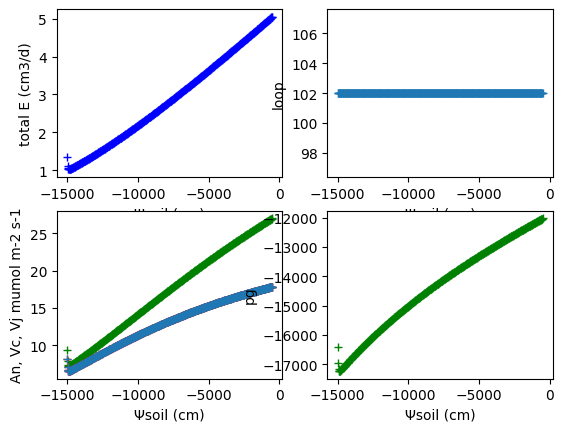

In [17]:
testtest=testPsoil
#testtest= testPsoiLight
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2, sharey=False)
axs[0, 0].plot(testtest[:len(Ev)], Ev, 'b+')
axs[0, 0].set(xlabel='Ψsoil (cm)', ylabel='total E (cm3/d)')
axs[0, 1].plot(testtest[:len(loop)], loop,'+')
axs[0, 1].set(xlabel='Ψsoil (cm)', ylabel='loop')
axs[1, 0].plot(testtest[:len(Vcrate)], Vcrate, 'g+')
axs[1, 0].plot(testtest[:len(Vjrate)], Vjrate, 'r+')
axs[1,0].plot(testtest[:len(Anrate)],np.array(Anrate),'+')
axs[1, 0].set(xlabel='Ψsoil (cm)', ylabel='An, Vc, Vj mumol m-2 s-1')
axs[1, 1].plot(testtest[:len(pg)], pg, 'g+')
axs[1, 1].set(xlabel='Ψsoil (cm)', ylabel='pg')
plt.show()

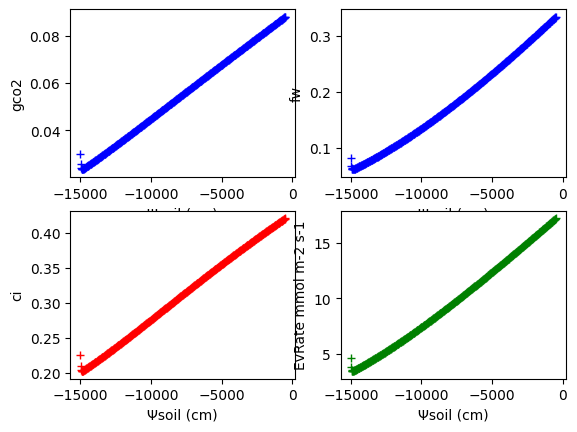

In [16]:

fig, axs = plt.subplots(2,2, sharey=False)
axs[0,0].plot(testtest[:len(gco2)], gco2, 'b+')
axs[0,0].set(xlabel='Ψsoil (cm)', ylabel='gco2')
axs[0,1].plot(testtest[:len(fw)], fw, 'b+')
axs[0,1].set(xlabel='Ψsoil (cm)', ylabel='fw')
axs[1, 0].plot(testtest[:len(fwold)], np.array(ci)/r.cs, 'r+')
axs[1, 0].set(xlabel='Ψsoil (cm)', ylabel='ci')
axs[1,1].plot(testtest[:len(fwVold)],np.array(EvRate)*1000 *18/1000 * 24. * 3600 * 1e-4, 'g+')
axs[1, 1].set(xlabel='Ψsoil (cm)', ylabel='EvRate mmol m-2 s-1')
plt.show()

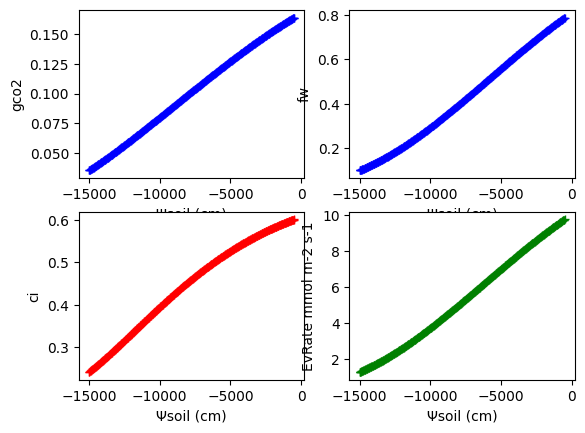

In [15]:
fig, axs = plt.subplots(2,2, sharey=False)
axs[0,0].plot(testtest[:len(gco2)], gco2, 'b+')
axs[0,0].set(xlabel='Ψsoil (cm)', ylabel='gco2')
axs[0,1].plot(testtest[:len(fw)], fw, 'b+')
axs[0,1].set(xlabel='Ψsoil (cm)', ylabel='fw')
axs[1, 0].plot(testtest[:len(fwold)], np.array(ci)/r.cs, 'r+')
axs[1, 0].set(xlabel='Ψsoil (cm)', ylabel='ci')
axs[1,1].plot(testtest[:len(fwVold)],np.array(EvRate)*1000 *18/1000 * 24. * 3600 * 1e-4, 'g+')
axs[1, 1].set(xlabel='Ψsoil (cm)', ylabel='EvRate mmol m-2 s-1')
plt.show()

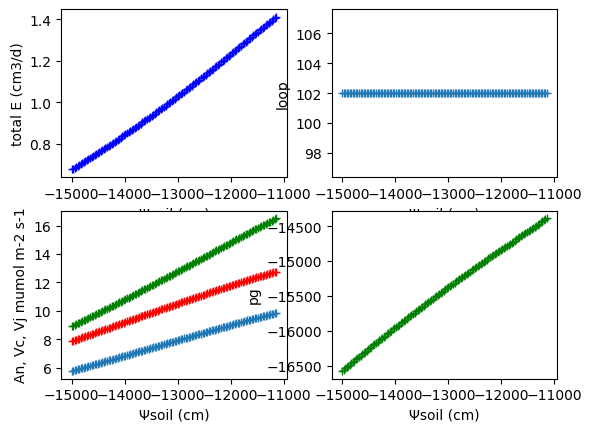

In [21]:
testtest=testPsoil
#testtest= testPsoiLight
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2, sharey=False)
axs[0, 0].plot(testtest[:len(Ev)], Ev, 'b+')
axs[0, 0].set(xlabel='Ψsoil (cm)', ylabel='total E (cm3/d)')
axs[0, 1].plot(testtest[:len(loop)], loop,'+')
axs[0, 1].set(xlabel='Ψsoil (cm)', ylabel='loop')
axs[1, 0].plot(testtest[:len(Vcrate)], Vcrate, 'g+')
axs[1, 0].plot(testtest[:len(Vjrate)], Vjrate, 'r+')
axs[1,0].plot(testtest[:len(Anrate)],np.array(Anrate),'+')
axs[1, 0].set(xlabel='Ψsoil (cm)', ylabel='An, Vc, Vj mumol m-2 s-1')
axs[1, 1].plot(testtest[:len(pg)], pg, 'g+')
axs[1, 1].set(xlabel='Ψsoil (cm)', ylabel='pg')
plt.show()

In [ ]:
 r.psiXyl = np.array(psiXylBU)*Pinit#np.full(len(r.psiXyl),Pinit)#
            r.pg = np.array(pbBU)*Pinit

In [32]:
r.psiXyl = np.array(psiXylBU)*Pinit#np.full(len(r.psiXyl),Pinit)#
r.pg = np.array(pbBU)*Pinit